In [31]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
import optuna
from scipy import stats

# Load Data
selected_features_labeled = pd.read_csv("selected_features.csv", sep='\t')

# 1. Data Preprocessing

In [32]:
selected_features_labeled

,SEQN,BPQ020,DIQ010,DID040,DIQ220,DIQ190A,DIQ190B,DIQ230,DID260,DIQ280,...,DIQ300D,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,63.0,0.0,1.0,1,1,55,6.9,...,9999,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,63.0,0.0,1.0,1,1,55,6.9,...,9999,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,0.0,0.0,1.0,1,0,0,0.0,...,0,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
3,31139.0,1.0,2.0,0.0,0.0,1.0,1,0,0,0.0,...,0,2,10.0,15.0,6.0,0,0.00,0.0,2.0,217
4,31139.0,1.0,2.0,0.0,0.0,1.0,1,0,0,0.0,...,0,2,40.0,30.0,6.0,0,0.00,0.0,2.0,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,41462.0,2.0,2.0,0.0,0.0,2.0,2,0,0,0.0,...,0,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4959,41462.0,2.0,2.0,0.0,0.0,2.0,2,0,0,0.0,...,0,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4960,41462.0,2.0,2.0,0.0,0.0,2.0,2,0,0,0.0,...,0,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4961,41465.0,2.0,2.0,0.0,0.0,1.0,1,0,0,0.0,...,0,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


In [33]:
## data cleaning

# Check for missing values and zero-value columns
zero_counts = (selected_features_labeled == 0).sum()
print("Total missing values: ", selected_features_labeled.isnull().sum().sum())
print("Missing values per column:\n", selected_features_labeled.isnull().sum())
print("Columns with all zero values:\n", zero_counts)

Total missing values:  0
Missing values per column:
 SEQN        0
BPQ020      0
DIQ010      0
DID040      0
DIQ220      0
DIQ190A     0
DIQ190B     0
DIQ230      0
DID260      0
DIQ280      0
DIQ300S     0
DIQ300D     0
PAQ180      0
PADACTIV    0
PADDURAT    0
SLD010H     0
LBXAPB      0
LBDINSI     0
LBXGH       0
RIAGENDR    0
RIDAGEMN    0
dtype: int64
Columns with all zero values:
 SEQN           0
BPQ020         0
DIQ010         0
DID040      4733
DIQ220      4914
DIQ190A        0
DIQ190B        0
DIQ230      4733
DID260      4765
DIQ280      4785
DIQ300S     4733
DIQ300D     4733
PAQ180         0
PADACTIV       0
PADDURAT       3
SLD010H        0
LBXAPB       349
LBDINSI      372
LBXGH        329
RIAGENDR       0
RIDAGEMN      32
dtype: int64


In [34]:
# Drop columns with around 9,000 missing values (NaN values get converted to 0)
selected_features_labeled = selected_features_labeled.drop(columns=['DID040', 'DIQ220', 'DIQ230', 'DID260', 'DIQ280', 'DIQ300S', 'DIQ300D'], errors='ignore')

In [35]:
selected_features_labeled

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
3,31139.0,1.0,2.0,1.0,1,2,10.0,15.0,6.0,0,0.00,0.0,2.0,217
4,31139.0,1.0,2.0,1.0,1,2,40.0,30.0,6.0,0,0.00,0.0,2.0,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4959,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4960,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4961,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


In [36]:
# Drop rows where certain columns contain zeros
cols_to_check = ['LBXAPB', 'LBDINSI', 'LBXGH', 'PADDURAT', 'RIDAGEMN']
selected_features_labeled = selected_features_labeled[(selected_features_labeled[cols_to_check] != 0).all(axis=1)]

In [37]:
selected_features_labeled

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
17,31148.0,2.0,2.0,2.0,2,2,23.0,60.0,7.0,47,62.76,5.0,2.0,194
18,31150.0,2.0,2.0,2.0,2,4,43.0,60.0,8.0,75,23.46,5.0,1.0,959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4959,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4960,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4961,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


In [38]:
# Save cleaned data
selected_features_labeled.to_csv("selected_features_final.csv", sep='\t', index=False)

In [39]:
selected_features_labeled

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
17,31148.0,2.0,2.0,2.0,2,2,23.0,60.0,7.0,47,62.76,5.0,2.0,194
18,31150.0,2.0,2.0,2.0,2,4,43.0,60.0,8.0,75,23.46,5.0,1.0,959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4959,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4960,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4961,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


## 1a. Further Preprocessing
### Dropped values similar to missing values ("Don't Know")

In [11]:
sfl_final = pd.read_csv("selected_features_final.csv", sep='\t')

In [12]:
sfl_final

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
3,31148.0,2.0,2.0,2.0,2,2,23.0,60.0,7.0,47,62.76,5.0,2.0,194
4,31150.0,2.0,2.0,2.0,2,4,43.0,60.0,8.0,75,23.46,5.0,1.0,959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4532,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4533,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4534,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


In [13]:
# columns: BPQ020, DIQ010, DIQ190A, DIQ190B, PAQ180, PADACTIV, SLD010H
# values: 9, 99, 71 (other for PADACTIV)

# List of columns and values to filter
filters = {
    'DIQ190A': '9',
    'DIQ190B': '9',
    'PAQ180': '9',
    'PADACTIV': '71',
    'SLD010H': '99',
}

# Apply filters sequentially, checking for empty DataFrames and column existence
for column, value in filters.items():
    if column in sfl_final.columns: 
        # Ensure the column data type is string
        sfl_final[column] = sfl_final[column].astype(str).str.strip()
        # Filter out rows where the column matches the value
        sfl_final = sfl_final[sfl_final[column] != str(value)]
    else:
        print(f"Column '{column}' not found. Skipping.")

print(sfl_final.columns)
sfl_final.to_csv("selected_features_final.csv", sep='\t', index=False)


Index(['SEQN', 'BPQ020', 'DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV',
       'PADDURAT', 'SLD010H', 'LBXAPB', 'LBDINSI', 'LBXGH', 'RIAGENDR',
       'RIDAGEMN'],
      dtype='object')


In [14]:
sfl_final

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,LBXAPB,LBDINSI,LBXGH,RIAGENDR,RIDAGEMN
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,75,53.94,7.1,1.0,842
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,75,53.94,7.1,1.0,842
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,111,87.06,5.9,1.0,882
3,31148.0,2.0,2.0,2.0,2,2,23.0,60.0,7.0,47,62.76,5.0,2.0,194
4,31150.0,2.0,2.0,2.0,2,4,43.0,60.0,8.0,75,23.46,5.0,1.0,959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4531,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,92,24.36,5.1,1.0,678
4532,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,92,24.36,5.1,1.0,678
4533,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,92,24.36,5.1,1.0,678
4534,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,84,342.54,5.6,2.0,222


# 2. Data Preparation for Analysis
## Criteria Filtering

In [22]:
combined_selected_features = pd.read_csv("selected_features_final.csv")
combined_selected_features.columns = combined_selected_features.columns.str.strip()

In [28]:
print(combined_selected_features)

     SEQN\tBPQ020\tDIQ010\tDIQ190A\tDIQ190B\tPAQ180\tPADACTIV\tPADDURAT\tSLD010H\tLBXAPB\tLBDINSI\tLBXGH\tRIAGENDR\tRIDAGEMN
0     31132.0\t1.0\t1.0\t1.0\t1\t2\t42.0\t40.0\t7.0\...                                                                     
1     31132.0\t1.0\t1.0\t1.0\t1\t2\t19.0\t240.0\t7.0...                                                                     
2     31134.0\t1.0\t2.0\t1.0\t1\t3\t42.0\t30.0\t7.0\...                                                                     
3     31148.0\t2.0\t2.0\t2.0\t2\t2\t23.0\t60.0\t7.0\...                                                                     
4     31150.0\t2.0\t2.0\t2.0\t2\t4\t43.0\t60.0\t8.0\...                                                                     
...                                                 ...                                                                     
4525  41462.0\t2.0\t2.0\t2.0\t2\t3\t42.0\t30.0\t8.0\...                                                                     


In [23]:
## preDM filter

# Reload cleaned dataset
""" combined_selected_features = pd.read_csv("selected_features_final.csv")
combined_selected_features.columns = combined_selected_features.columns.str.strip() """

# Define PreDM condition
preDM_criteria = (combined_selected_features['LBDINSI'] >= 100) | (combined_selected_features['LBXAPB'] >= 110) | (combined_selected_features['LBXGH'] >= 5.5)

# Add 'PreDM' label
combined_selected_features['PreDM'] = preDM_criteria.astype(int)

# Drop features used for labeling
combined_selected_features = combined_selected_features.drop(columns=['LBDINSI', 'LBXAPB', 'LBXGH'], errors='ignore')

# Save final labeled dataset
combined_selected_features.to_csv("selected_features_labeled_final.csv", sep='\t', index=False)


KeyError: 'LBDINSI'

In [20]:
print(combined_selected_features.columns.tolist())


['SEQN\tBPQ020\tDIQ010\tDIQ190A\tDIQ190B\tPAQ180\tPADACTIV\tPADDURAT\tSLD010H\tLBXAPB\tLBDINSI\tLBXGH\tRIAGENDR\tRIDAGEMN']


In [88]:
combined_selected_features

,SEQN\tBPQ020\tDIQ010\tDIQ190A\tDIQ190B\tPAQ180\tPADACTIV\tPADDURAT\tSLD010H\tLBXAPB\tLBDINSI\tLBXGH\tRIAGENDR\tRIDAGEMN
0,31132.0\t1.0\t1.0\t1.0\t1\t2\t42.0\t40.0\t7.0\...
1,31132.0\t1.0\t1.0\t1.0\t1\t2\t19.0\t240.0\t7.0...
2,31134.0\t1.0\t2.0\t1.0\t1\t3\t42.0\t30.0\t7.0\...
3,31148.0\t2.0\t2.0\t2.0\t2\t2\t23.0\t60.0\t7.0\...
4,31150.0\t2.0\t2.0\t2.0\t2\t4\t43.0\t60.0\t8.0\...
...,...
4525,41462.0\t2.0\t2.0\t2.0\t2\t3\t42.0\t30.0\t8.0\...
4526,41462.0\t2.0\t2.0\t2.0\t2\t3\t20.0\t120.0\t8.0...
4527,41462.0\t2.0\t2.0\t2.0\t2\t3\t29.0\t10.0\t8.0\...
4528,41465.0\t2.0\t2.0\t1.0\t1\t1\t42.0\t30.0\t6.0\...


In [40]:
# prepare data for analysis, train/test
# Load labeled dataset
labeled_selected_features = pd.read_csv("selected_features_labeled_final.csv", sep='\t')

# Define features and target
#X_wo_RIAGENDR = labeled_selected_features[['BPQ020', 'DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV', 'PADDURAT', 'SLD010H','RIDAGEMN']]
X = labeled_selected_features[['SEQN', 'BPQ020', 'DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV', 'PADDURAT', 'SLD010H','RIAGENDR', 'RIDAGEMN']]

y = labeled_selected_features["PreDM"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.7, random_state=42)
#X_wo_RIAGENDR_train, X_wo_RIAGENDR_test, y_train, y_test = train_test_split(X_wo_RIAGENDR, y, test_size=0.2, train_size=0.7, random_state=42)

# Standardize features
scaler = StandardScaler()

#X_scaled = scaler.fit_transform(X)
#X_test_scaled = scaler.transform(X)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#X_wo_RIAGENDR_train_scaled = scaler.fit_transform(X_wo_RIAGENDR)
# X_w_RIAGENDR_test_scaled = scaler.transform(X_test)


# 3. Model Training and Evaluation

In [42]:
## train/evaluate model

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}\n", classification_report(y_test, y_pred_dt))

# Logistic Regression
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
accuracy_log = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log:.2f}\n", classification_report(y_test, y_pred_log_reg))

# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train, verbose=False)
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}\n", classification_report(y_test, y_pred_xgb))

# Support Vector Machine (SVM)
svm_model = SVC(random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}\n", classification_report(y_test, y_pred_svm))

# Random Forest
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}\n", classification_report(y_test, y_pred_rf))


Decision Tree Accuracy: 0.87
               precision    recall  f1-score   support

           0       0.87      0.86      0.87       437
           1       0.87      0.88      0.88       469

    accuracy                           0.87       906
   macro avg       0.87      0.87      0.87       906
weighted avg       0.87      0.87      0.87       906

Logistic Regression Accuracy: 0.68
               precision    recall  f1-score   support

           0       0.64      0.76      0.70       437
           1       0.73      0.61      0.67       469

    accuracy                           0.68       906
   macro avg       0.69      0.68      0.68       906
weighted avg       0.69      0.68      0.68       906

XGBoost Accuracy: 0.86
               precision    recall  f1-score   support

           0       0.84      0.86      0.85       437
           1       0.87      0.85      0.86       469

    accuracy                           0.86       906
   macro avg       0.86      0.86     

# 4. Cross Validation of Models

### with RIAGENDR variable

In [43]:
## cross-validation of models

kf = KFold(n_splits=10, shuffle=True)
    #random_state = 42
#kf = StratifiedKFold(n_splits=10, shuffle=True)

cv_scores = {}

dt_scores = cross_val_score(DecisionTreeClassifier(random_state=42), X_scaled, y, cv=kf, scoring='accuracy')
cv_scores['Decision Tree'] = dt_scores
print(f"Decision Tree Mean CV Accuracy: {dt_scores.mean():.2f}")


# Logistic Regression CV    #class_weight='balanced', 
lr_scores = cross_val_score(LogisticRegression(max_iter=1000, random_state=42), X_scaled, y, cv=kf, scoring='accuracy')
cv_scores['Logistic Regression'] = lr_scores
print(f"Logistic Regression Mean CV Accuracy: {lr_scores.mean():.2f}")

# XGBoost CV   #, max_depth=5
xgb_scores = cross_val_score(xgb.XGBClassifier(eval_metric='logloss', random_state=41), X_scaled, y, cv=kf, scoring='accuracy')
cv_scores['XGBoost'] = xgb_scores
print(f"XGBoost Mean CV Accuracy: {xgb_scores.mean():.2f}")
#print(sns.boxplot(xgb_scores))""

# SVM CV
svm_scores = cross_val_score(SVC(random_state=42), X_scaled, y, cv=kf, scoring='accuracy')
cv_scores['SVM'] = svm_scores
print(f"SVM Mean CV Accuracy: {svm_scores.mean():.2f}")

# Random Forest CV
rf_scores = cross_val_score(RandomForestClassifier(random_state=1), X_scaled, y, cv=kf, scoring='accuracy')
cv_scores['Random Forest'] = rf_scores
print(f"Random Forest Mean CV Accuracy: {rf_scores.mean():.2f}")


Decision Tree Mean CV Accuracy: 0.90
Logistic Regression Mean CV Accuracy: 0.66
XGBoost Mean CV Accuracy: 0.89
SVM Mean CV Accuracy: 0.69
Random Forest Mean CV Accuracy: 0.89


### visualizing the accuracies using bar chart

In [ ]:
mean_scores_df = pd.DataFrame({
    'Model': list(cv_scores.keys()),
    'Mean Accuracy': [np.mean(scores) for scores in cv_scores.values()]
})

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Model', y='Mean Accuracy', data=mean_scores_df, palette='viridis')

# Annotate bars
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.005, f'{height:.3f}', ha='center', fontsize=10)

plt.title('Mean Cross-Validation Accuracy for Each Model')
plt.ylabel('Mean Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=15)
plt.ylim(0.6, 1.0)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### without RIAGENDR variable

In [ ]:
## cross-validation of models

kf = KFold(n_splits=10, shuffle=True)
    #random_state = 42

# Decision Tree CV
dt_scores = cross_val_score(DecisionTreeClassifier(random_state=42), X_wo_RIAGENDR_train_scaled, y, cv=kf, scoring='accuracy')
print(f"Decision Tree Mean CV Accuracy: {dt_scores.mean(): .2f}")

# Logistic Regression CV
lr_scores = cross_val_score(LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42), X_wo_RIAGENDR_train_scaled, y, cv=kf, scoring='accuracy')
print(f"Logistic Regression Mean CV Accuracy: {lr_scores.mean():.2f}")

# XGBoost CV
xgb_scores = cross_val_score(xgb.XGBClassifier(eval_metric='logloss', random_state=42), X_wo_RIAGENDR_train_scaled, y, cv=kf, scoring='accuracy')
print(f"XGBoost Mean CV Accuracy: {xgb_scores.mean():.2f}")
#print(sns.boxplot(xgb_scores))


# 5. Regularization and T-test to Optimize Code
## Visualization (Box Plot) of XGBoost Scores
### using reg_alpha and reg_lambda

In [ ]:
## box plot of xgboost scores with and without alpha

xgb_scores_w_alpha = cross_val_score(xgb.XGBClassifier(eval_metric='logloss', random_state=42,reg_lambda= 0.010667454567077583, reg_alpha=0.04426281481067611), X_train_scaled, y_train, cv=kf, scoring='f1')
xgb_scores_wo_alpha = cross_val_score(xgb.XGBClassifier(eval_metric='logloss', random_state=42), X_scaled, y_train, cv=kf, scoring='accuracy')

box_plots = [xgb_scores_w_alpha, xgb_scores_wo_alpha]

fig, axes = plt.subplots(figsize=(10, 5))

sns.boxplot(data=box_plots, ax=axes)
axes.set_title("XGBoost Scores (With and Without Alpha)")
axes.set_xticklabels(["With Alpha", "Without Alpha"])

""" sns.boxplot(x=xgb_scores_wo_alpha, ax=axes[1])
axes[1].set_title("XGBoost Scores (Without Alpha)") """

plt.tight_layout()

plt.savefig("final_visualizations/xgb_scores_alpha.png", dpi=300, bbox_inches="tight")
#plt.savefig("final_visualizations/xgb_scores_wo_alpha.png", dpi=300, bbox_inches="tight")

plt.show()

""" print(f"XGBoost Mean CV Accuracy: {xgb_scores.mean():.2f}")
print(sns.boxplot(xgb_scores_w_alpha))
print(sns.boxplot(xgb_scores_wo_alpha)) """

## Hyperparameter tuning (reg_lambda and reg_alpha)
### with a custom range of values

In [ ]:
# lowest variance estimation using reg_lambda and reg_alpha
# calculation of values

# parameter ranges
reg_lambda_values = [0.1, 0.2, 0.3, 0.4, 0.5]
reg_alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5]

results = {}

for reg_lambda in reg_lambda_values:
    for reg_alpha in reg_alpha_values:
        model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, reg_lambda=reg_lambda, reg_alpha=reg_alpha)
        scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='f1')
        variance = np.var(scores)
        
        results[(reg_lambda, reg_alpha)] = variance

# Find the pair with the lowest variance
best_params = min(results, key=results.get)
best_lambda, best_alpha = best_params
lowest_variance = results[best_params]

# Print best values
print(f"Best reg_lambda: {best_lambda}")
print(f"Best reg_alpha: {best_alpha}")
print(f"Lowest variance: {lowest_variance:.6f}")




## Hyperparameter tuning (t-test and chi-square test)

### identify continous and categorical features

In [ ]:
categorical_cols = ['DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV', 'RIAGENDR']
#categorical_cols = ['BPQ020', 'DIQ010', 'DIQ190A', 'DIQ190B', 'PAQ180', 'PADACTIV', 'RIAGENDR']
continuous_cols = ['PADDURAT', 'SLD010H', 'RIDAGEMN']

#X.loc[:, continuous_cols_to_convert] = X[continuous_cols_to_convert].astype('category')

#categorical_cols = X.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_cols)

## chi-square test

# Identify continuous columns
#continuous_vars = X.select_dtypes(include=['float64', 'int64']).columns  
print("Continuous Columns:", continuous_cols)



### t-test for continous variables

In [ ]:
# T-test for variable significance (univariate t-tests)

p_values = {}
for col in continuous_cols:
    group1 = X[y == 0][col]  # Values where PreDM is 0
    group2 = X[y == 1][col]  # Values where PreDM is 1
    t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False) # Welch's t-test
    p_values[col] = p_val
""" print("\nP-values for each variable (univariate t-tests):")
for col, p_val in p_values.items():
    print(f"{col}: {p_val:.4f}") """

## save p-values to csv
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'P-value'])
p_values_df.to_csv("selected_features_final_p-values_t_test.csv", index=False)

print(p_values_df)

print("\nP-values for each variable (univariate t-tests) saved to variable_p_values.csv")

### chi-square test for categorical variables

In [ ]:
# Dictionary to store p-values from Chi-Square tests
chi2_p_values = {}

# Iterate through each categorical column identified
print("\nPerforming Chi-Square tests for association with target variable 'y'...")
for col in categorical_cols:
    # Create a contingency table (cross-tabulation) between the feature and the target
    contingency_table = pd.crosstab(X[col], y)

    # Perform the Chi-Square test of independence
    # This test checks if the observed frequencies in the table deviate significantly
    # from the frequencies that would be expected if there were no association
    # between the feature (col) and the target (y).
    try:
        chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

        # Store the p-value
        chi2_p_values[col] = p_val
        # print(f"Chi-Square test for {col}: p-value = {p_val:.4f}") # Optional: print individual results

    except ValueError as e:
        # Handle cases where chi2_contingency might fail (e.g., all values in a row/column are 0)
        print(f"Could not perform Chi-Square test for {col}: {e}")
        chi2_p_values[col] = None # Or np.nan

print("\nP-values for each categorical variable (Chi-Square tests):")
for col, p_val in chi2_p_values.items():
    if p_val is not None:
        print(f"{col}: {p_val:.4f}")
    else:
        print(f"{col}: Test failed")

# Save Chi-Square p-values to a CSV file
chi2_p_values_df = pd.DataFrame(list(chi2_p_values.items()), columns=['Variable', 'P-value_Chi2'])
chi2_p_values_df.to_csv("selected_features_final_p-values_chi2_test.csv", index=False)

print("\nChi-Square P-values saved to categorical_features_p_values_chi2.csv")

## Hyperparameter tuning (Optuna)

In [ ]:
## optuna hyperparameter optimization

# Define the objective function
def objective(trial):
    # Suggest values for reg_lambda and reg_alpha
    """ reg_lambda = trial.suggest_loguniform("reg_lambda", 0.01, 100)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 0.01, 100) """
    reg_alpha = trial.suggest_float("reg_alpha", 1e-5, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-5, 10.0, log=True)

    # Define the model with the suggested hyperparameters
    model = xgb.XGBClassifier(
        eval_metric='logloss',
        random_state=2,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha
    )

    # Perform cross-validation and compute the mean F1 score
    scores = cross_val_score(model, X_scaled, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    return np.mean(scores)  # Optuna will maximize this value

# Create and run the optimization study
study = optuna.create_study(direction="maximize")  # We want to maximize the F1 score
study.optimize(objective, n_trials=50)  # Run 50 trials

print("Best trial:")
print(f"  Value (Accuracy): {study.best_trial.value:.4f}")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

# Add optimized XGBoost to CV
xgb_reg_model = XGBClassifier(
    eval_metric='logloss',
    random_state=2,
    **study.best_trial.params
)
xgb_reg_scores = cross_val_score(xgb_reg_model, X_scaled, y, cv=kf, scoring='accuracy')
cv_scores['XGBoost (Optuna)'] = xgb_reg_scores
print(f"XGBoost (Optuna) Mean CV Accuracy: {xgb_reg_scores.mean():.2f}")

""" # Get the best hyperparameters
best_params = study.best_params
best_score = study.best_value

print(f"Best reg_lambda: {best_params['reg_lambda']}")
print(f"Best reg_alpha: {best_params['reg_alpha']}")
print(f"Best mean F1 score: {best_score:.4f}") """


# 6. Confusion Matrix Analysis and Identifying Correct/Incorrect Values

## pairplot visualization of entire dataset before confusion matrix analysis

In [ ]:
## pairplot before confusion matrix of entire dataset
entire_dataset = [col for col in labeled_selected_features.columns 
                       if labeled_selected_features[col].dtype in ['float64', 'int64']]
    
plt.figure(figsize=(10,6))

sns.pairplot(labeled_selected_features, vars=entire_dataset, hue='PreDM', diag_kind='kde')
plt.title("Pairplot of all variables in dataset", fontsize=10)
print("test line")
plt.savefig("final_visualizations/pairplot_before_division_cm.png")
    
plt.show()


## confusion matrix analysis

In [ ]:
## confusion matrix using XGBoost model

# Function to plot confusion matrix
def plot_confusion_matrix(cm, fold_num):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {fold_num}")
    #plt.savefig('final_visualizations/confusion_matrix.png')
    #plt.show()

# XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, alpha=0.5)

fold_cm = []
total_samples = 0
all_predictions = np.zeros(len(y))  # Start with zeros for all predictions

for fold_num, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    xgb_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = xgb_model.predict(X_test_cv)

    all_predictions[test_index] = y_pred_cv

    #print(y_pred_cv)

    cm = confusion_matrix(y_test_cv, y_pred_cv)
    fold_cm.append(cm)

    print(f"Confusion Matrix for Fold {fold_num}: \n{cm}\n")

     # Plot confusion matrix after each fold
    #plot_confusion_matrix(cm, fold_num)

# Compare predictions to actual values and label them as correct (1) or incorrect (0)
correct_predictions = (all_predictions == y).astype(int)

labeled_selected_features["Prediction_Correct"] = correct_predictions
    
labeled_selected_features.to_csv("selected_features_labeled_final_with_predictions.csv", sep='\t', index=False)

# Count of correct predictions (where Prediction_Correct == 1)
correct_count = labeled_selected_features["Prediction_Correct"].sum()

# Count of incorrect predictions (where Prediction_Correct == 0)
incorrect_count = len(labeled_selected_features) - correct_count

# Print the results
print(f"Correct Predictions: {correct_count}")
print(f"Incorrect Predictions: {incorrect_count}")

print(correct_predictions)


In [497]:
# comparison of correct and wrong values
correct = labeled_selected_features[labeled_selected_features['Prediction_Correct']==1]
wrong = labeled_selected_features[labeled_selected_features['Prediction_Correct']==0]

# 7. Analysis of Correct/Incorrect Values

In [ ]:
# statistics of correct and wrong values
correct_desc = correct.describe()
wrong_desc = wrong.describe()
display(correct_desc)
display(wrong_desc)

correct_desc.to_csv("selected_features_final_correct_desc_stats.csv")
wrong_desc.to_csv("selected_features_final_wrong_desc_stats.csv")

In [499]:
# correct prediction versus wrong prediction

# correct and wrong values 

correct.to_csv("selected_features_final_with_predictions_correctValues.csv", sep='\t')
wrong.to_csv("selected_features_final_with_predictions_wrongValues.csv", sep='\t')

In [ ]:
# Transpose the correct and wrong values to make it suitable for pairplot (each column represents a feature)

correct_transposed = correct.T
wrong_transposed = wrong.T

print(correct_transposed)
print(wrong_transposed)

In [ ]:
## pairplot of correct and wrong values

sns.pairplot(correct, hue='PreDM', diag_kind='kde')
plt.suptitle("Pairplot of Correct Values ", y=1.02)
#sns.pairplot(labeled_selected_features, vars=renamed_vars, hue='PreDM', diag_kind='kde')
plt.savefig("final_visualizations/pairplot_correct_values.png")

sns.pairplot(wrong,  hue='PreDM', diag_kind='kde')
plt.suptitle("Pairplot of Wrong Values ", y=1.02)
plt.savefig("final_visualizations/pairplot_wrong_values.png")

#plt.show()

# 8. Visualizations of Dataset
## SHAP values

In [ ]:
# SHAP values visualization using xgboost - entire dataset

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

print("Shape of X:", X.shape)
print("Shape of shap_values:", shap_values.shape)

shap.summary_plot(shap_values, X, show=False)

plt.suptitle("SHAP Plot of Entire Dataset ", y=1.05, fontsize=14)
plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.savefig("final_visualizations/SHAP_plot_entireDataset.png", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
# SHAP values visualization using xgboost - correct values
# training data - X_train
feature_names = X_train.columns.tolist()

#feature_names = xgb_model.feature_names
features_only_correct = correct[feature_names]

explainer = shap.TreeExplainer(xgb_model)
shap_values_correct = explainer.shap_values(features_only_correct)

print("Shape of Correct Values (features only):", features_only_correct.shape)
print("Shape of shap_values_correct:", shap_values_correct.shape)

shap.summary_plot(shap_values_correct, features_only_correct, show=False)

plt.suptitle("SHAP Plot of Correct Values ", y=1.05, fontsize=14)
plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.savefig("final_visualizations/SHAP_plot_correctValues.png", bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
# SHAP values visualization using xgboost - wrong values
# training data - X_train
feature_names = X_train.columns.tolist()

#feature_names = xgb_model.feature_names
features_only_wrong = wrong[feature_names]

explainer = shap.TreeExplainer(xgb_model)
shap_values_wrong = explainer.shap_values(features_only_wrong)

print("Shape of Wrong Values (features only):", features_only_wrong.shape)
print("Shape of shap_values_wrong:", shap_values_wrong.shape)

shap.summary_plot(shap_values_wrong, features_only_wrong, show=False)

plt.suptitle("SHAP Plot of Wrong Values ", y=1.05, fontsize=14)
plt.tight_layout()

plt.subplots_adjust(top=0.9)

plt.savefig("final_visualizations/SHAP_plot_wrongValues.png", bbox_inches='tight', dpi=300)
plt.show()


## 9. Modifications
### additional data visualizations (on poster)

In [57]:
import pandas as pd

df = pd.read_csv("selected_features_labeled_final.csv",sep="\t")

In [58]:
df.describe()

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,RIAGENDR,RIDAGEMN,PreDM
count,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.00000,4530.000000,4530.000000,4530.000000,4530.000000
mean,36456.702428,1.803753,1.964459,1.798896,1.734879,2.313024,29.465121,58.50287,7.006843,1.479691,430.410596,0.500442
std,2960.043928,0.441433,0.259625,0.400870,0.441447,0.838220,13.323306,65.08107,2.726140,0.499643,218.839914,0.500055
min,31132.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.00000,1.000000,1.000000,192.000000,0.000000
25%,33853.250000,2.000000,2.000000,2.000000,1.000000,2.000000,15.000000,20.00000,6.000000,1.000000,231.000000,0.000000
50%,36503.000000,2.000000,2.000000,2.000000,2.000000,2.000000,33.000000,30.00000,7.000000,1.000000,367.000000,1.000000
75%,38988.750000,2.000000,2.000000,2.000000,2.000000,3.000000,42.000000,60.00000,8.000000,2.000000,580.000000,1.000000
max,41472.000000,9.000000,9.000000,2.000000,2.000000,4.000000,71.000000,600.00000,99.000000,2.000000,1019.000000,1.000000


In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import optuna

# 1. Feature / Target
X = df.drop('PreDM', axis=1)
y = df['PreDM']

# 2. Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Objective 
def objective(trial):
    
    reg_alpha = trial.suggest_float("reg_alpha", 1e-5, 10.0, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-5, 10.0, log=True)
    
    # XGBoost 
    model = XGBClassifier(
        eval_metric="logloss",
        random_state=2,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda
    )

    
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    return scores.mean()

# 5. Optuna study 
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 6. 
print("Best trial:")
print(f"  Value (Accuracy): {study.best_trial.value:.4f}")
print("  Params:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-10 17:11:56,418] A new study created in memory with name: no-name-d148a7d6-e166-4285-a7f0-fd9c738fb868
[I 2025-04-10 17:11:57,386] Trial 0 finished with value: 0.8935982339955849 and parameters: {'reg_alpha': 0.0011318657112007696, 'reg_lambda': 0.03749746602446197}. Best is trial 0 with value: 0.8935982339955849.
[I 2025-04-10 17:11:58,221] Trial 1 finished with value: 0.8984547461368653 and parameters: {'reg_alpha': 0.0008952094246083002, 'reg_lambda': 0.011741093542788548}. Best is trial 1 with value: 0.8984547461368653.
[I 2025-04-10 17:11:59,051] Trial 2 finished with value: 0.8902869757174393 and parameters: {'reg_alpha': 3.375508590111191e-05, 'reg_lambda': 0.6126736691412574}. Best is trial 1 with value: 0.8984547461368653.
[I 2025-04-10 17:12:00,025] Trial 3 finished with value: 0.8931567328918323 and parameters: {'reg_alpha': 0.0008097751866876248, 'reg_lambda': 1.3820060392297638e-05}. Best is trial 1 with value: 0.8984547461368653.
[I 2025-04-10 17:12:00,993] Tri

Best trial:
  Value (Accuracy): 0.8985
  Params:
    reg_alpha: 0.0008952094246083002
    reg_lambda: 0.011741093542788548


In [60]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier  # XGBoost 

X = df.drop('PreDM', axis=1)
#LBDINSI >= 100, LBXAPB >= 110, LBXGH >= 5.5
y = df['PreDM']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=10,shuffle=True)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=1),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=40),
    'XGBoost_reg': XGBClassifier(eval_metric='logloss', random_state=2,reg_alpha=0.015243985126367762,reg_lambda=0.00037552039707253616)

}

cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')
    cv_scores[name] = scores
    print(f"{name} Accuracy: {cv_scores[name].mean()}")




Logistic Regression Accuracy: 0.6633554083885209
SVM Accuracy: 0.6905077262693157
Random Forest Accuracy: 0.8883002207505518
Decision Tree Accuracy: 0.8860927152317881
XGBoost Accuracy: 0.8955849889624723
XGBoost_reg Accuracy: 0.8944812362030904


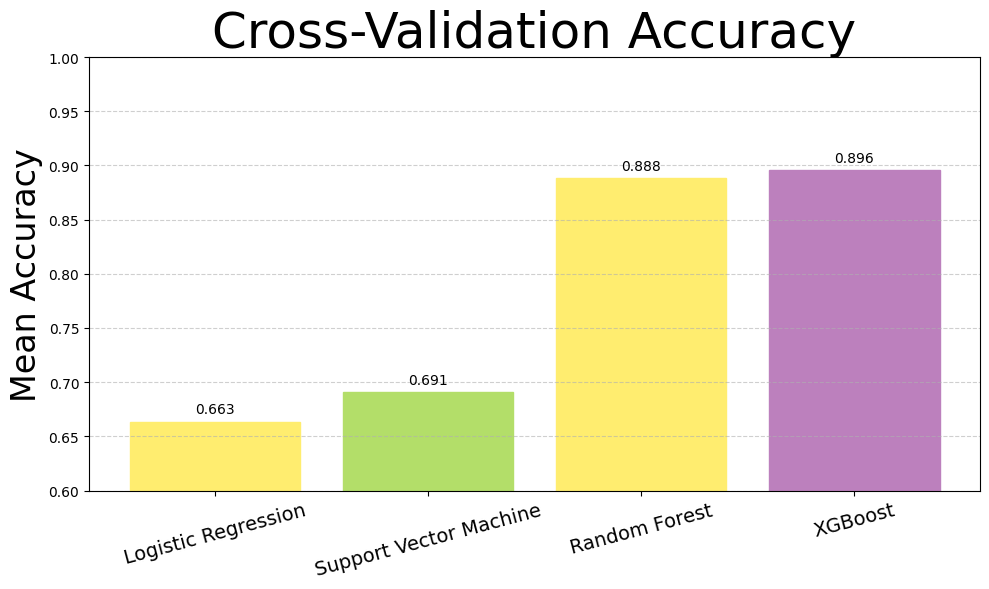

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Display name mapping
model_name_mapping = {
    'Logistic Regression': 'Logistic Regression',
    'SVM': 'Support Vector Machine',
    'Random Forest': 'Random Forest',
    'XGBoost': 'XGBoost'
}

# Select only the models you want to plot
selected_models = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost']

# Prepare display names and mean scores
model_names = [model_name_mapping[model] for model in selected_models]
mean_scores = [np.mean(cv_scores[model]) for model in selected_models]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mean_scores)

# Color the bars randomly from Set3
for bar in bars:
    bar.set_color(plt.cm.Set3(np.random.rand()))

# Annotate scores above bars
for i, score in enumerate(mean_scores):
    plt.text(i, score + 0.005, f"{score:.3f}", ha='center', va='bottom', fontsize=10)

plt.ylim(0.6, 1.0)
plt.title("Cross-Validation Accuracy", fontsize=36)
plt.ylabel("Mean Accuracy", fontsize=24)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.xticks(rotation=15, fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\Kannan\AppData\Local\Temp\ipykernel_33948\3580337796.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, patch_artist=True, labels=labels)


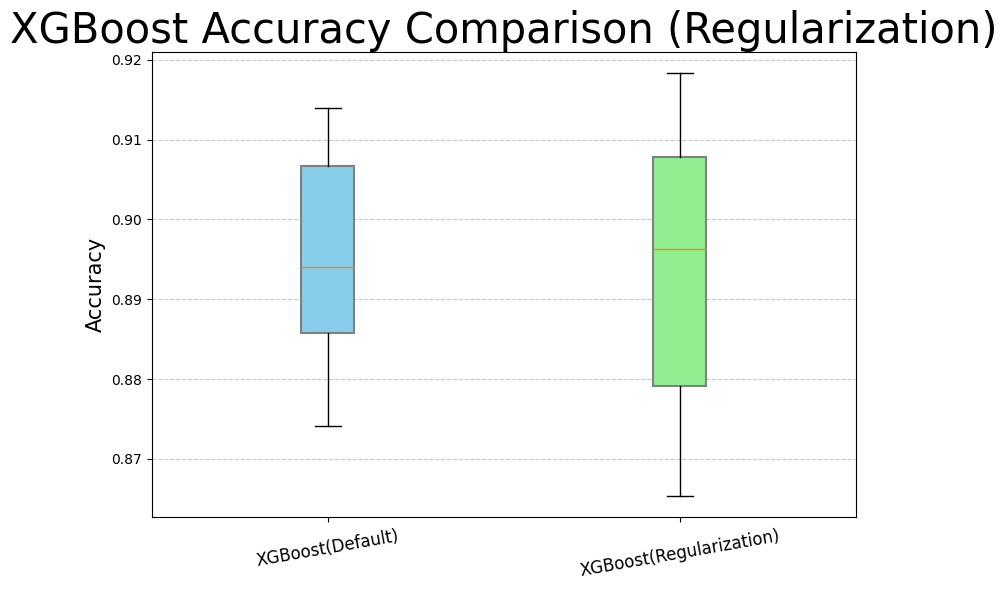

In [62]:
import matplotlib.pyplot as plt
import numpy as np


data = [cv_scores['XGBoost'], cv_scores['XGBoost_reg']]
labels = ['XGBoost(Default)', 'XGBoost(Regularization)']


plt.figure(figsize=(8, 6))


box = plt.boxplot(data, patch_artist=True, labels=labels)


colors = ['skyblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('gray')
    patch.set_linewidth(1.5)


plt.title('XGBoost Accuracy Comparison (Regularization)', fontsize=30)
plt.ylabel('Accuracy', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.xticks(rotation=10, fontsize=12)

plt.tight_layout()
plt.show()


 99%|===================| 4478/4530 [00:20<00:00]        

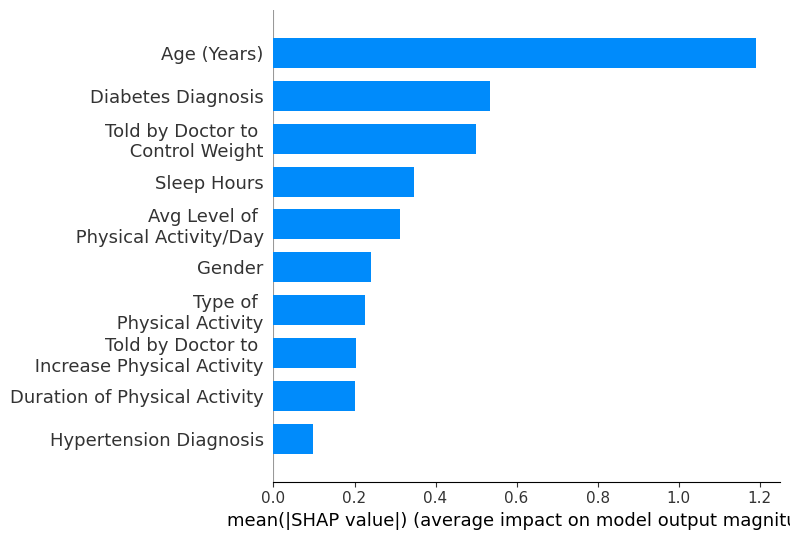

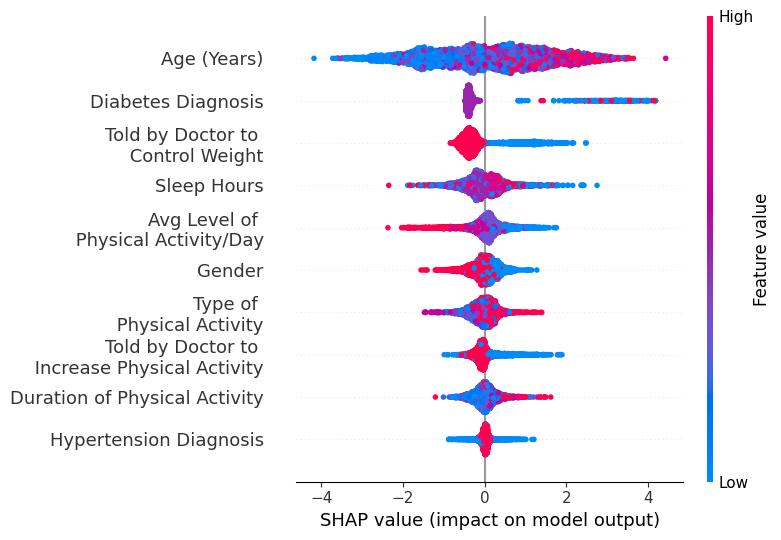

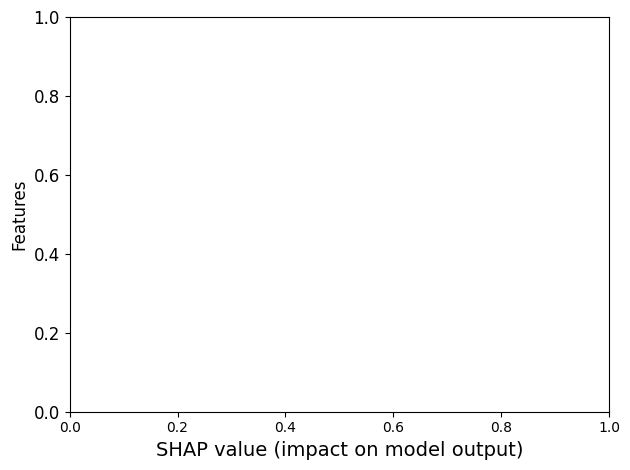

In [63]:
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

feature_name_mapping = {
    'RIDAGEMN': 'Age (Years)',
    'DIQ010': 'Diabetes Diagnosis',
    'DIQ190A': 'Told by Doctor to \n Control Weight',
    'SLD010H': 'Sleep Hours',
    'PAQ180': 'Avg Level of \n Physical Activity/Day',
    'RIAGENDR': 'Gender',
    'PADACTIV': 'Type of \n Physical Activity',
    'DIQ190B': 'Told by Doctor to \n Increase Physical Activity',
    'PADDURAT': 'Duration of Physical Activity',
    'BPQ020': 'Hypertension Diagnosis',

}

# Rename the columns of the DataFrame
df_renamed = df.rename(columns=feature_name_mapping)

# 1. Feature / Target using the renamed DataFrame
X_renamed = df_renamed.drop(['SEQN','PreDM'], axis=1)
y = df_renamed['PreDM']

scaler = StandardScaler()
X_scaled_renamed = scaler.fit_transform(X_renamed)

# 2. XGBoost 
model = XGBClassifier(
    eval_metric='logloss',
    random_state=40,
    reg_alpha=0.028746265595634254,
    reg_lambda=0.020011163481365255
)
model.fit(X_scaled_renamed, y)

# 3. SHAP explainer 
explainer = shap.Explainer(model, X_scaled_renamed, feature_names=X_renamed.columns)
shap_values = explainer(X_scaled_renamed)

shap.summary_plot(shap_values, feature_names=X_renamed.columns, plot_type="bar")
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)", fontsize=18)
plt.yticks(fontsize=25)
#plt.title("Feature Importance", fontsize=18) # Optional: Add a title with adjusted font size
plt.tight_layout() # Adjust layout to prevent labels from overlapping


shap.summary_plot(shap_values, feature_names=X_renamed.columns)
plt.xlabel("SHAP value (impact on model output)", fontsize=14)
plt.ylabel("Features", fontsize=12) # Add a y-axis label with adjusted font size
plt.yticks(fontsize=12)
#plt.title("SHAP Values per Feature", fontsize=16) # Optional: Add a title with adjusted font size
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# 4. SHAP summary plot
#shap.summary_plot(shap_values, feature_names=X_renamed.columns, plot_type="bar")  # feature importance bar plot
#shap.summary_plot(shap_values, feature_names=X_renamed.columns)  # dot plot
